In [1]:
!pip install segmentation-models --quiet
import tensorflow as tf

import keras
import keras.backend as K
import keras.callbacks as cbs
import cv2
import pandas as pd
import numpy as np
import os, shutil
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, train_test_split

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
train=pd.read_csv('../input/cloud-images-resized/train_384x576.csv')
train['Image']=train['Image_Label'].map(lambda x: x.split("_")[0])
train['Label']=train['Image_Label'].map(lambda x: x.split("_")[1])
train2=pd.DataFrame({'Image':train['Image'][::4]})
train2['e1']=train['EncodedPixels'][::4].values
train2['e2']=train['EncodedPixels'][1::4].values
train2['e3']=train['EncodedPixels'][2::4].values
train2['e4']=train['EncodedPixels'][3::4].values
train2.set_index('Image', drop=True, inplace=True)
train2=train2.fillna('')
train2[['d1','d2','d3','d4']]=(train2[['e1','e2','e3','e4']]!='').astype(int)
train2.head()

,e1,e2,e3,e4,d1,d2,d3,d4
Image,,,,,,,,
0011165.jpg,20056 257 20440 257 20824 257 21208 257 21592 ...,102245 275 102629 275 103013 275 103397 275 10...,,,1,1,0,0
002be4f.jpg,17668 241 18051 242 18435 242 18819 242 19203 ...,100850 142 101234 142 101618 142 102002 142 10...,,5074 96 5458 96 5842 96 6226 96 6610 96 6994 9...,1,1,0,1
0031ae9.jpg,579 190 963 190 1347 190 1731 190 2115 190 249...,178 193 562 193 946 193 1330 193 1714 193 2098...,,49583 107 49967 107 50351 107 50735 107 51119 ...,1,1,0,1
0035239.jpg,,7684 127 8068 127 8452 127 8836 127 9220 127 9...,5267 104 5651 104 6035 104 6419 104 6803 104 7...,,0,1,1,0
003994e.jpg,178332 27 178715 28 179089 2 179092 35 179470 ...,,26639 114 27023 114 27407 114 27791 114 28175 ...,1924 133 2308 134 2692 134 3076 134 3460 134 3...,1,0,1,1


In [3]:
def rle2mask(rle,shrink=1,shape=(2100,1400)):
    rle=rle.split()
    starts,lengths=[np.asarray(x,dtype=int) for (x) in(rle[::2],rle[1::2]) ]
    starts-=1
    ends=starts+lengths
    mask=np.zeros(shape[0]*shape[1],dtype='uint8')
    
    for lo,hi in zip(starts,ends):
        mask[lo:hi]=1
        
    return mask.reshape(shape).T[::shrink,::shrink]
        

In [4]:
import albumentations as albu
%env SM_FRAMEWORK=tf.keras
import segmentation_models as sm

env: SM_FRAMEWORK=tf.keras
Segmentation Models: using `tf.keras` framework.


In [5]:
class DataGenerator(keras.utils.Sequence):
    def __init__(self,list_ids,shrink1=1,shrink2=1,dimheight= 352, width=544,
                path='../input/cloud-images-resized/train_images_384x576/',
                 flips=False, augment=False,batch_size=32,scale=1/128,sub=1,mode='train',shuffle=False):
        self.shrink1=shrink1
        self.shrink2=shrink2
        self.mode=mode
        self.path=path
        self.dim=dim
        self.augment=augment
        self.height=height
        self.width=width
        self.list_ids=list_ids
        self.batch_size=batch_size
        self.flips=flips
        self.scale=scale
        self.sub=sub
        self.shuffle=shuffle
        self.on_epoch_end()
        
    def __len__(self):
        ct= int(np.floor(len(self.list_ids)/(self.batch_size)))
        if len(self.list_ids)>ct*self.batch_size:
            ct+=1
        return ct
    
    def __getitem__(self,index):
        indexes=self.indexes[index*self.batch_size : (index+1)*self.batch_size]
        X,msk=self.__generate_data(indexes)
#         print(X[1])
        if self.augment : X,msk=self.__batch_aug(X,msk)
        if (self.mode=='train')|(self.mode=='val'):
            return X,msk
        else : return X
        
    def __generate_data(self,indexes):
        
        lnn= len(indexes) ;ex=self.shrink1 ;ax =self.shrink2
        X = np.empty((lnn,self.height, self.width,3),dtype=np.float32)
        msk=np.empty((lnn,self.height,self.width,4),dtype=np.float32)
        
        for i in range(lnn):
            img=cv2.imread(self.path+self.list_ids[indexes[i]])
            hflips=False ; vflips=False
            if(self.flips):
                if np.random.uniform(0,1)>0.5 : hflips=True
                if np.random.uniform(0,1)>0.5 : vflips=True
            if hflips:
                img=cv2.flip(img,1)
            if vflips:
                img=cv2.flip(img,0)
            
            ## shake augment
            a=np.random.randint(0,self.dim[0]//ax//ex-self.width/ax+1)
            
            b=np.random.randint(0,self.dim[1]//ax//ex-self.height/ax+1)
            
            if (self.mode=='predict'):
                a=(self.dim[0]//ex//ax-self.width//ax)//2
                b=(self.dim[1]//ex//ax-self.height//ax)//2
                
            img=img[b*ax:self.height+b*ax,a*ax:self.width+a*ax]
            X[i]=img*self.scale - self.sub
            
            
            if (self.mode!='predict'):
                
                for j in range(1,5):
                    rle=train2.loc[self.list_ids[indexes[i]],'e'+str(j)]
                    mask=rle2mask(rle,shrink=ex*ax,shape=self.dim)
                    if hflips:
                        mask=np.flip(mask,axis=1)
                    if vflips:
                        mask=np.flip(mask,axis=0)
                    msk[i,:,:,j-1]=mask[b:self.height//ax+b,a:self.width//ax+a]
                    
                    
        return X,msk
    
    def on_epoch_end(self):
        self.indexes=np.arange(int(len(self.list_ids)))
        if self.shuffle: np.random.shuffle(self.indexes)
            
    def __random_transform(self, img,mask):
        composition=albu.Compose([
        albu.ShiftScaleRotate(scale_limit=0.1,rotate_limit=30,p=0.5)
        ])
        
        composed=composition(image=img,mask=mask)
#         print(composed['image'])
        return composed['image'],composed['mask']
        
    def __batch_aug(self,img_batch,mask_batch):
        for i in  range(img_batch.shape[0]):
            img_batch[i],mask_batch[i]=self.__random_transform(img_batch[i],mask_batch[i])
#         print(img_batch[1])
        return img_batch, mask_batch
                
                
                
            
                

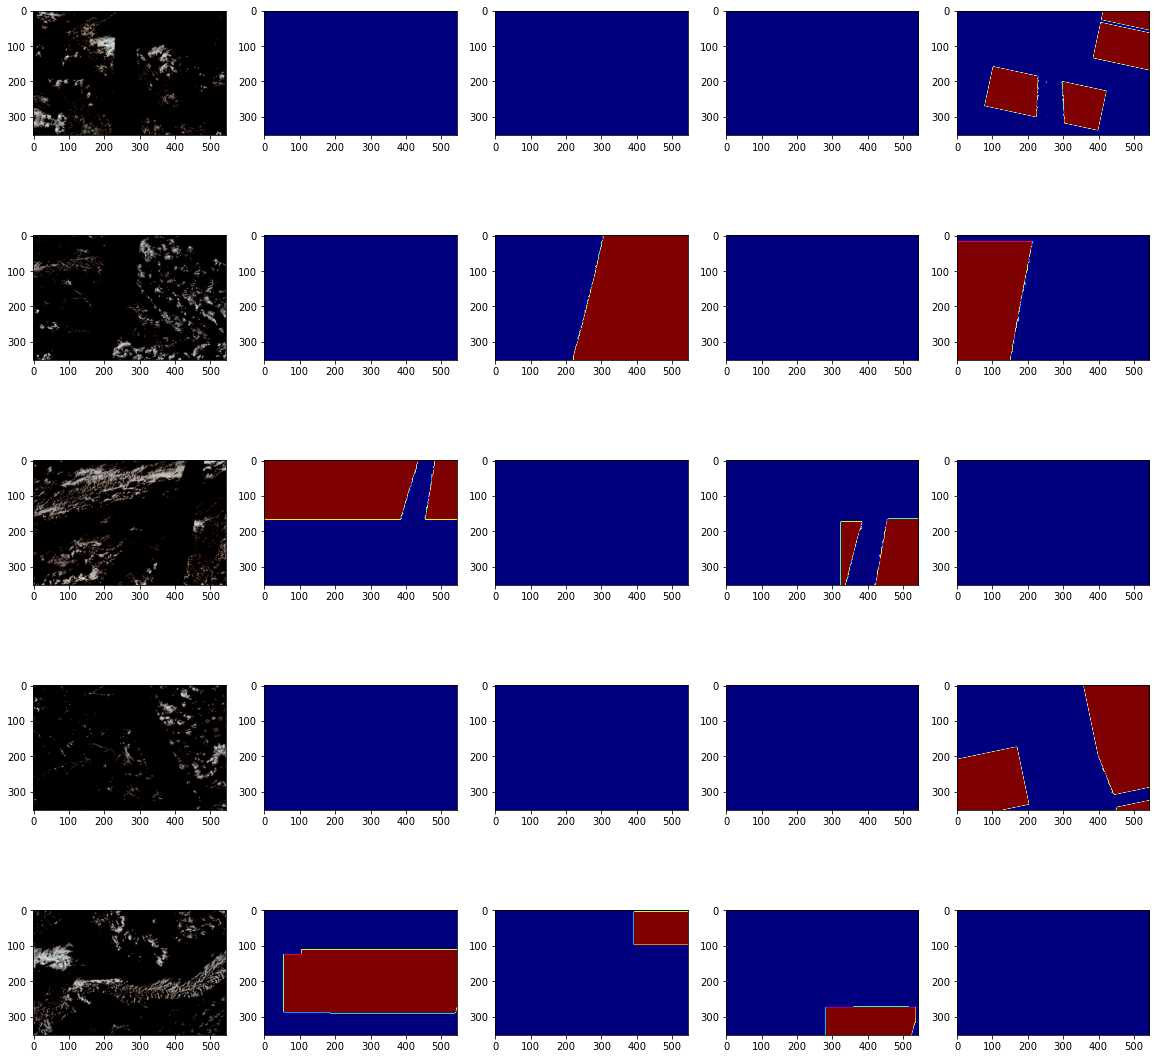

In [6]:
train_gen=DataGenerator(train2.index,augment=True,shuffle=True)
X,msk=train_gen.__getitem__(3)
# print(X.shape,msk.shape)
fig,ax=plt.subplots(5,5,figsize=(20,20))

for i in range(5):
    ax[i,0].imshow(X[i])
    ax[i,1].imshow(X[i])
    ax[i,1].imshow(msk[i,:,:,0],'jet')
    ax[i,2].imshow(X[i])
    ax[i,2].imshow(msk[i,:,:,1],'jet')
    ax[i,3].imshow(X[i])
    ax[i,3].imshow(msk[i,:,:,2],'jet')
    ax[i,4].imshow(X[i])
    ax[i,4].imshow(msk[i,:,:,3],'jet')
    
plt.show()

In [7]:
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

In [16]:
filters = [256, 128, 64, 32, 16]
REDUCTION = 0; RED = 2**REDUCTION
filters = filters[:5-REDUCTION]

jaccard_loss = sm.losses.JaccardLoss() 

train_idx,val_idx=train_test_split(train2.index,test_size=0.1)

model_list=['efficientnetb1','efficientnetb2','efficientnetb3','efficientnetb4']
bs_list=[10,10,10,8]



In [9]:
## due to kaggle GPU time limit ristrictions KFOld is not being used . 

In [10]:
from numba import cuda


In [ ]:
# from sklearn.model_selection import StratifiedKFold
# skf=StratifiedKFold(n_splits=5,shuffle=False)
for i,model_name in enumerate(model_list):
#     for train_idx,val_idx in skf.spli(train2):
    print("*"*25)
    print("now training unet with ",model_name," encoder")
    print("*"*25)
    BATCH_SIZE = bs_list[i]
    opt =keras.optimizers.Adam(learning_rate=0.001)


    train_generator = DataGenerator(
        train_idx, flips=True, augment=True, shuffle=True, shrink2=RED, batch_size=BATCH_SIZE,
    )

    
    val_generator = DataGenerator(
        val_idx, shrink2=RED, batch_size=BATCH_SIZE
    )

    model = sm.Unet(
        model_name, 
        classes=4,
        encoder_weights='imagenet',
        decoder_filters = filters,
        input_shape=(None, None, 3),
        activation='sigmoid'
    )
    model.compile(optimizer=opt, loss=jaccard_loss, metrics=[dice_coef])#,kaggle_dice,kaggle_acc])

    checkpoint = cbs.ModelCheckpoint(model_name+'.h5', save_best_only=True)#add fold number if kfold is being used
    es = cbs.EarlyStopping(monitor='val_dice_coef', min_delta=0.001, patience=5, verbose=1, mode='max')
    rlr = cbs.ReduceLROnPlateau(monitor='val_dice_coef', factor=0.5, patience=2, verbose=1, mode='max', min_delta=0.001)

    history = model.fit_generator(
         train_generator,
         validation_data=val_generator,
         callbacks=[rlr, es, checkpoint],
         epochs=25,
         verbose=1, workers=2
    )
    
    del model,history,train_generator,val_generator
#     cuda.select_device(0)
#     cuda.close()

*************************
now training unet with  efficientnetb1  encoder
*************************
27164672/27164032 [==============================] - 3s 0us/step
Epoch 1/25
500/500 [==============================] - 323s 646ms/step - loss: 0.6778 - dice_coef: 0.4660 - val_loss: 0.6666 - val_dice_coef: 0.4908
Epoch 2/25
500/500 [==============================] - 317s 633ms/step - loss: 0.6198 - dice_coef: 0.5456 - val_loss: 0.6509 - val_dice_coef: 0.5376
Epoch 3/25
500/500 [==============================] - 318s 635ms/step - loss: 0.6092 - dice_coef: 0.5572 - val_loss: 0.6004 - val_dice_coef: 0.5802
Epoch 4/25
500/500 [==============================] - 316s 632ms/step - loss: 0.6030 - dice_coef: 0.5643 - val_loss: 0.6055 - val_dice_coef: 0.5693
Epoch 5/25
500/500 [==============================] - ETA: 0s - loss: 0.5988 - dice_coef: 0.5681
Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
500/500 [==============================] - 317s 634ms/step - loss:

Epoch 20/25
500/500 [==============================] - 322s 644ms/step - loss: 0.5530 - dice_coef: 0.6154 - val_loss: 0.5545 - val_dice_coef: 0.6276
Epoch 21/25
500/500 [==============================] - ETA: 0s - loss: 0.5501 - dice_coef: 0.6157
Epoch 00021: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
500/500 [==============================] - 322s 644ms/step - loss: 0.5501 - dice_coef: 0.6157 - val_loss: 0.5582 - val_dice_coef: 0.6236
Epoch 22/25
500/500 [==============================] - 323s 647ms/step - loss: 0.5513 - dice_coef: 0.6164 - val_loss: 0.5554 - val_dice_coef: 0.6261
Epoch 00022: early stopping
*************************
now training unet with  efficientnetb3  encoder
*************************
44113920/44107200 [==============================] - 4s 0us/step
Epoch 1/25
500/500 [==============================] - 384s 767ms/step - loss: 0.6868 - dice_coef: 0.4595 - val_loss: 0.6733 - val_dice_coef: 0.4876
Epoch 2/25
500/500 [==========================

624/624 [==============================] - 472s 757ms/step - loss: 0.5712 - dice_coef: 0.5974 - val_loss: 0.5536 - val_dice_coef: 0.6295
Epoch 17/25
515/624 [=======================>......] - ETA: 1:19 - loss: 0.5664 - dice_coef: 0.6020

In [11]:
sub = pd.read_csv('../input/understanding_cloud_organization/sample_submission.csv')
sub['Image'] = sub['Image_Label'].map(lambda x: x.split('.')[0])
sub['Label'] = sub['Image_Label'].map(lambda x: x.split('_')[1])
# LOAD TEST CLASSIFIER PREDICTIONS
sub['p'] = pd.read_csv('../input/cloud-classifiers/pred_cls.csv').p.values
sub['p'] += np.load('../input/cloud-classifiers/pred_cls0.npy').reshape((-1)) * 0.5
sub['p'] += pd.read_csv('../input/cloud-classifiers/pred_cls3.csv').p.values * 3.0
sub['p'] += np.load('/kaggle/input/cloud-classifiers/pred_cls4b.npy') * 0.6
sub['p'] /= 5.1

In [12]:
USE_TTA=False
DO_TEST=True

In [13]:
def mask2rleXXX(img0, shape=(576,384), grow=(525,350)):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    a = (shape[1]-img0.shape[0])//2
    b = (shape[0]-img0.shape[1])//2
    img = np.zeros((shape[1],shape[0]),dtype=np.uint8)
    img[a:a+img0.shape[0],b:b+img0.shape[1]] = img0
    img = cv2.resize(img,grow)
    
    pixels= img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [25]:
model1 = sm.Unet(
        'efficientnetb1', 
        classes=4,
#         encoder_weights='imagenet',
        decoder_filters = filters,
        input_shape=(None, None, 3),
        activation='sigmoid',
    weights='../input/cloud-my/efficientnetb1.h5'
    )

model2 = sm.Unet(
        'efficientnetb2', 
        classes=4,
#         encoder_weights='imagenet',
        decoder_filters = filters,
        input_shape=(None, None, 3),
        activation='sigmoid',
    weights='../input/cloud-my/efficientnetb2.h5'
    
    )

model3 = sm.Unet(
        'efficientnetb3', 
        classes=4,
        encoder_weights='imagenet',
        decoder_filters = filters,
        input_shape=(None, None, 3),
        activation='sigmoid',
    weights='../input/cloud-my/efficientnetb3.h5'
    )

model4 = sm.Unet(
        'efficientnetb4', 
        classes=4,
        encoder_weights='imagenet',
        decoder_filters = filters,
        input_shape=(None, None, 3),
        activation='sigmoid',
    weights='../input/cloud-my/efficientnetb4.h5'
    )




In [27]:
print('Computing masks for',len(sub)//4,'test images with 4 models'); sub.EncodedPixels = ''
PTH = '../input/cloud-images-resized/test_images_384x576/'; bs = 16
if USE_TTA: bs=1
test_gen = DataGenerator(sub.Image[::4].values+'.jpg', width=576, height=384, batch_size=bs, mode='predict',path=PTH)

sz = 20000.*(576/525)*(384/350)/RED/RED

pixt = [0.5,0.5,0.5,0.35] #; pixt = [0.4,0.4,0.4,0.4]
szt = [25000., 20000., 22500., 15000.] #; szt = [20000., 20000., 20000., 20000.]
for k in range(len(szt)): szt[k] = szt[k]*(576./525.)*(384./350.)/RED/RED

if DO_TEST:
    for b,batch in enumerate(test_gen):
        btc = model1.predict_on_batch(batch)
        btc += model2.predict_on_batch(batch)
        btc += model3.predict_on_batch(batch)
#         btc += model4.predict_on_batch(batch)
        btc /= 3.0

        for j in range(btc.shape[0]):
            for i in range(btc.shape[-1]):
                mask = (btc[j,:,:,i]>pixt[i]).astype(int); rle = ''
                if np.sum(mask)>szt[i]: rle = mask2rleXXX( mask ,shape=(576//RED,384//RED))
                sub.iloc[4*(bs*b+j)+i,1] = rle
        if b%(100//bs)==0: print(b*bs,', ',end='')


    sub[['Image_Label','EncodedPixels']].to_csv('sub_seg.csv',index=False)
    sub.loc[(sub.p<0.5)&(sub.Label=='Fish'),'EncodedPixels'] = ''
    sub.loc[(sub.p<0.3)&(sub.Label=='Flower'),'EncodedPixels'] = ''
    sub.loc[(sub.p<0.5)&(sub.Label=='Gravel'),'EncodedPixels'] = ''
    sub.loc[(sub.p<0.5)&(sub.Label=='Sugar'),'EncodedPixels'] = ''
    sub[['Image_Label','EncodedPixels']].to_csv('submission.csv',index=False)

sub.head(10)

Computing masks for 3698 test images with 4 models
0 , 96 , 192 , 288 , 384 , 480 , 576 , 672 , 768 , 864 , 960 , 1056 , 1152 , 1248 , 1344 , 1440 , 1536 , 1632 , 1728 , 1824 , 1920 , 2016 , 2112 , 2208 , 2304 , 2400 , 2496 , 2592 , 2688 , 2784 , 2880 , 2976 , 3072 , 3168 , 3264 , 3360 , 3456 , 3552 , 3648 , 

,Image_Label,EncodedPixels,Image,Label,p
0,002f507.jpg_Fish,,002f507,Fish,0.115576
1,002f507.jpg_Flower,,002f507,Flower,0.014768
2,002f507.jpg_Gravel,1 348 351 348 701 349 1051 55299 56351 349 567...,002f507,Gravel,0.998530
3,002f507.jpg_Sugar,,002f507,Sugar,0.403651
4,0035ae9.jpg_Fish,,0035ae9,Fish,0.398813
5,0035ae9.jpg_Flower,,0035ae9,Flower,0.110705
6,0035ae9.jpg_Gravel,44 307 392 309 742 309 1092 309 1442 309 1792 ...,0035ae9,Gravel,0.809908
7,0035ae9.jpg_Sugar,231 118 581 118 931 120 1281 120 1630 121 1980...,0035ae9,Sugar,0.839289
8,0038327.jpg_Fish,,0038327,Fish,0.355603
9,0038327.jpg_Flower,,0038327,Flower,0.601632


In [ ]:
path='../input/understanding_cloud_organization/test_images'
k=0
fig,ax=plt.subplots(10,5,figsize=(20,20))

for i in range(10):
    ax[i,0].imshow(cv2.imread(path+'/'+sub.Image_Label[k].split("_")[0]))
    for j in range(1,5): 
        rle=sub.iloc[k,1]
        
        mask=rle2mask(rle)
        ax[i,j].imshow(mask,'jet')
        k+=1
plt.show()